# Develop Preprocessing Pipeline

In [1]:
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
# Switch to matplotlib backend
mne.viz.set_browser_backend('matplotlib')

#=============SETTINGS============
RAW_DATA_DIR = "../data/raw"
SUBJECT_ID="S001"
TASK_PARAGIDM="left_right_hand"

Using matplotlib as 2D backend.


## Utils

In [11]:
#Run Type to Task Map
run_type_to_task = {
    "R01": {
        "name": "Baseline - Eyes Open",
        "task_type": "baseline",
        "labels": None
    },
    "R02": {
        "name": "Baseline - Eyes Closed",
        "task_type": "baseline",
        "labels": None
    },
    "R03": {
        "name": "Task 1 - Real Left/Right Fist",
        "task_type": "motor_execution",
        "paradigm": "left_right_hand",
        "labels": {
            "T1": "left_fist",
            "T2": "right_fist"
        }
    },
    "R04": {
        "name": "Task 2 - Imagine Left/Right Fist",
        "task_type": "motor_imagery",
        "paradigm": "left_right_hand",
        "labels": {
            "T1": "left_fist",
            "T2": "right_fist"
        }
    },
    "R05": {
        "name": "Task 3 - Real Fists/Feet",
        "task_type": "motor_execution",
        "paradigm": "hands_feet",
        "labels": {
            "T1": "both_fists",
            "T2": "both_feet"
        }
    },
    "R06": {
        "name": "Task 4 - Imagine Fists/Feet",
        "task_type": "motor_imagery",
        "paradigm": "hands_feet",
        "labels": {
            "T1": "both_fists",
            "T2": "both_feet"
        }
    },
    "R07": {
        "name": "Task 1 - Real Left/Right Fist",
        "task_type": "motor_execution",
        "paradigm": "left_right_hand",
        "labels": {
            "T1": "left_fist",
            "T2": "right_fist"
        }
    },
    "R08": {
        "name": "Task 2 - Imagine Left/Right Fist",
        "task_type": "motor_imagery",
        "paradigm": "left_right_hand",
        "labels": {
            "T1": "left_fist",
            "T2": "right_fist"
        }
    },
    "R09": {
        "name": "Task 3 - Real Fists/Feet",
        "task_type": "motor_execution",
        "paradigm": "hands_feet",
        "labels": {
            "T1": "both_fists",
            "T2": "both_feet"
        }
    },
    "R10": {
        "name": "Task 4 - Imagine Fists/Feet",
        "task_type": "motor_imagery",
        "paradigm": "hands_feet",
        "labels": {
            "T1": "both_fists",
            "T2": "both_feet"
        }
    },
    "R11": {
        "name": "Task 1 - Real Left/Right Fist",
        "task_type": "motor_execution",
        "paradigm": "left_right_hand",
        "labels": {
            "T1": "left_fist",
            "T2": "right_fist"
        }
    },
    "R12": {
        "name": "Task 2 - Imagine Left/Right Fist",
        "task_type": "motor_imagery",
        "paradigm": "left_right_hand",
        "labels": {
            "T1": "left_fist",
            "T2": "right_fist"
        }
    },
    "R13": {
        "name": "Task 3 - Real Fists/Feet",
        "task_type": "motor_execution",
        "paradigm": "hands_feet",
        "labels": {
            "T1": "both_fists",
            "T2": "both_feet"
        }
    },
    "R14": {
        "name": "Task 4 - Imagine Fists/Feet",
        "task_type": "motor_imagery",
        "paradigm": "hands_feet",
        "labels": {
            "T1": "both_fists",
            "T2": "both_feet"
        }
    }
}

MOTOR_CHANNELS = [
    'C3..',   # Left motor cortex (primary)
    'Cz..',   # Central motor area (feet)
    'C4..',   # Right motor cortex (primary)
    'Fc3.',   # Left frontal-central (premotor)
    'Fc4.',   # Right frontal-central (premotor)
    'Cp3.',   # Left central-parietal (sensorimotor)
    'Cp4.',   # Right central-parietal (sensorimotor)
    'C5..',   # Left lateral motor
    'C1..',   # Left medial motor
    'C2..',   # Right medial motor
    'C6..',   # Right lateral motor
    'Fc1.',   # Left medial frontal-central
    'Fc2.',   # Right medial frontal-central
    'Fc5.',   # Left lateral frontal-central
    'Fc6.',   # Right lateral frontal-central
    'Cp1.',   # Left medial central-parietal
    'Cp2.',   # Right medial central-parietal
    'Cp5.',   # Left lateral central-parietal
    'Cp6.'    # Right lateral central-parietal
]

def rename_annotations(raw, run_type):
    """
    Rename MNE annotations to readable task labels
    """
    task_info = run_type_to_task[run_type]
    
    if task_info['labels'] is not None:
        # Map T0, T1, T2 to readable names
        annotation_mapping = {
            'T0': 'rest',
            'T1': task_info['labels']['T1'],
            'T2': task_info['labels']['T2']
        }
        
        raw.annotations.rename(annotation_mapping)
    
    # Extract events with new names
    events, event_dict = mne.events_from_annotations(raw)
    
    return event_dict

def select_eeg_files_for_subject_by_paradigm(subject_id, paradigm):
    """
    Select motor imagery EEG files for a subject by paradigm
    """
    matching_runs = [
        run_id for run_id, info in run_type_to_task.items()
        if info.get('paradigm') == paradigm and info['task_type'] == 'motor_imagery'
    ]
    
    return [
        os.path.join(RAW_DATA_DIR, subject_id, f"{subject_id}{run_id}.edf")
        for run_id in sorted(matching_runs)
    ]


def load_and_concatenate_to_epochs(files, tmin=-0.5, tmax=3.5, picks=MOTOR_CHANNELS):
    """
    Load multiple EDF files and concatenate into single Epochs object
    """
    epochs_list = []
    
    for filepath in files:
        # Extract run_id
        run_id = extract_task_id(filepath)
        
        # Load raw
        raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
        
        # Rename annotations
        event_dict = rename_annotations(raw, run_id)
        
        # Get events (exclude rest)
        events, _ = mne.events_from_annotations(raw)
        event_id = {k: v for k, v in event_dict.items() if k != 'rest'}
        
        # Create epochs
        epochs = mne.Epochs(
            raw, events, event_id=event_id,
            tmin=tmin, tmax=tmax,
            baseline=None,
            picks=picks,
            preload=True,
            verbose=False
        )
        
        epochs_list.append(epochs)
    
    # Concatenate
    return mne.concatenate_epochs(epochs_list)



### Run Types Reference
| Run # | Task | Description | Classification Task |
|-------|------|-------------|---------------------|
| R01 | Baseline | Eyes open | - |
| R02 | Baseline | Eyes closed | - |
| **R03, R07, R11** | Task 1 | Real left/right fist | **T1=Left, T2=Right** |
| **R04, R08, R12** | Task 2 | Imagine left/right fist | **T1=Left, T2=Right** |
| **R05, R09, R13** | Task 3 | Real fists/feet | **T1=Fists, T2=Feet** |
| **R06, R10, R14** | Task 4 | Imagine fists/feet | **T1=Fists, T2=Feet** |


In [12]:
eeg_data_files = select_eeg_files_for_subject_by_paradigm(SUBJECT_ID, TASK_PARAGIDM)
print("Files: ", eeg_data_files)


Files:  ['../data/raw/S001/S001R04.edf', '../data/raw/S001/S001R08.edf', '../data/raw/S001/S001R12.edf']


## Load Data

In [8]:
#read data
extract_task_id = lambda filepath: 'R' + filepath.split('R')[-1].split('.')[0]


sample_task_id =  extract_task_id(eeg_data_files[0])

raw_eeg_data_sample = mne.io.read_raw_edf(eeg_data_files[0])
rename_annotations(raw_eeg_data_sample, sample_task_id)
events, event_dict = mne.events_from_annotations(raw_eeg_data_sample)
event_id = {k: v for k, v in event_dict.items() if k != 'rest'}

Extracting EDF parameters from ../data/raw/S001/S001R04.edf...
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]


Subject S001 | TaskID: R04
Motor-Channels Electords Measurements (25 sec duration)


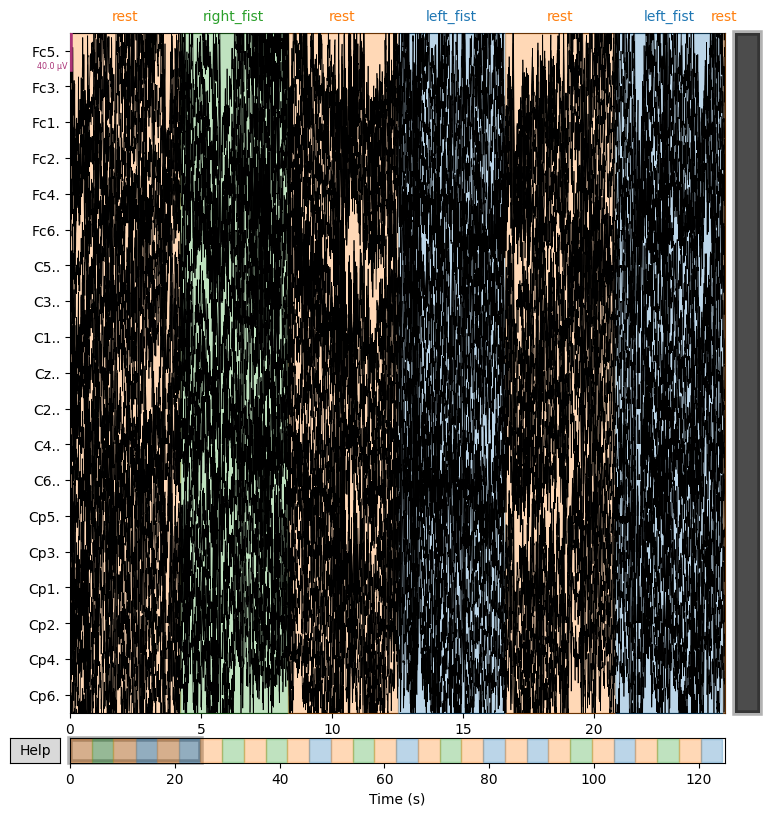

In [10]:

plot_duration=25

print(f"Subject {SUBJECT_ID} | TaskID: {sample_task_id}")
print(f"Motor-Channels Electords Measurements ({plot_duration} sec duration)")
raw_eeg_data_sample.plot(
    duration=plot_duration,
    picks=MOTOR_CHANNELS #Focus on Motor Channels
    
)
print()

### Epoching Time-Series

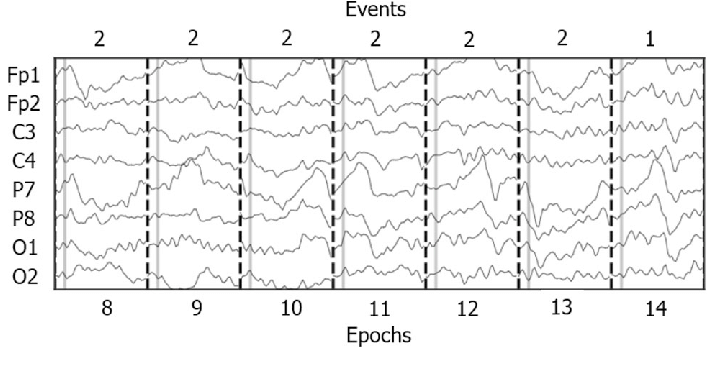![image.png]

In [13]:
TMIN=-0.5 #sec before event
TMAX=3.5 #sec after event

concatenated_epochs = load_and_concatenate_to_epochs(files=eeg_data_files,
                                                    tmin=TMIN,
                                                    tmax=TMAX,
                                                    picks=MOTOR_CHANNELS)


Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Used Annotations descriptions: [np.str_('left_fist'), np.str_('rest'), np.str_('right_fist')]
Not setting metadata
45 matching events found
No baseline correction applied


/tmp/ipykernel_94845/2216046590.py:214: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  return mne.concatenate_epochs(epochs_list)
